# Visualize prediction

In [1]:
import json

with open('/home/dxtien/dxtien_research/nmduy/data_covid_creation/data_pneu_bbox.json') as f:
    data_bbox = json.load(f)

full_id = list(data_bbox.keys())
short_id = [x.split('/')[-1] for x in full_id]


In [2]:
full_id[0]

'images_006/00013118_008.png'

In [3]:
bbox_img = data_bbox[full_id[0]]
bbox_img

{'note': 'atelectasis',
 'bbox': [225.08474576271198,
  547.0192167637709,
  86.7796610169491,
  79.18644067796609]}

In [4]:
import torch
from torch.backends import cudnn

from backbone import EfficientDetBackbone
import cv2
import matplotlib.pyplot as plt
import numpy as np

from efficientdet.utils import BBoxTransform, ClipBoxes
from utils.utils import preprocess, invert_affine, postprocess

import os
os.chdir('/home/dxtien/dxtien_research/nmduy/Yet-Another-EfficientDet-Pytorch')

DataFolder = '/home/dxtien/dxtien_research/COVID/CXR8/'

compound_coef = 4
force_input_size = None  # set None to use default size
img_path = DataFolder + full_id[0]


threshold = 0.2
iou_threshold = 0.2

use_cuda = True
use_float16 = False
cudnn.fastest = True
cudnn.benchmark = True

obj_list = ['abnormal']

# tf bilinear interpolation is different from any other's, just make do
input_sizes = [512, 640, 768, 896, 1024, 1280, 1280, 1536]
input_size = input_sizes[compound_coef] if force_input_size is None else force_input_size
ori_imgs, framed_imgs, framed_metas = preprocess(img_path, max_size=input_size)

ori_imgs_plot = [np.copy(x) for x in ori_imgs]

if use_cuda:
    x = torch.stack([torch.from_numpy(fi).cuda() for fi in framed_imgs], 0)
else:
    x = torch.stack([torch.from_numpy(fi) for fi in framed_imgs], 0)

x = x.to(torch.float32 if not use_float16 else torch.float16).permute(0, 3, 1, 2)

model = EfficientDetBackbone(compound_coef=compound_coef, num_classes=len(obj_list),

                             # replace this part with your project's anchor config
                             ratios=[(1.0, 1.0), (1.4, 0.7), (0.7, 1.4)],
                             scales=[2 ** 0, 2 ** (1.0 / 3.0), 2 ** (2.0 / 3.0)])

model.load_state_dict(torch.load('logs/pneumonia_head_only_with_none/best_model/efficientdet-d4_68_11385.pth'))
model.requires_grad_(False)
model.eval()

if use_cuda:
    model = model.cuda()
if use_float16:
    model = model.half()

with torch.no_grad():
    features, regression, classification, anchors = model(x)

    regressBoxes = BBoxTransform()
    clipBoxes = ClipBoxes()

    out = postprocess(x,
                      anchors, regression, classification,
                      regressBoxes, clipBoxes,
                      threshold, iou_threshold)

out = invert_affine(framed_metas, out)



In [5]:
out

[{'rois': array([], dtype=float64),
  'class_ids': array([], dtype=float64),
  'scores': array([], dtype=float64)}]

In [45]:
ori_imgs_plot = [np.copy(x) for x in ori_imgs]

In [6]:
ori_imgs_plot = [np.copy(x) for x in ori_imgs]
for i in range(len(ori_imgs_plot)):
    if len(out[i]['rois']) == 0:
        continue

    for j in range(len(out[i]['rois'])):
        score = float(out[i]['scores'][j])
        if score >= 0.1:
          (x1, y1, x2, y2) = out[i]['rois'][j].astype(np.int)
          cv2.rectangle(ori_imgs_plot[i], (x1, y1), (x2, y2), (255, 0, 0), 2)
          obj = obj_list[out[i]['class_ids'][j]]
          

        #   cv2.putText(ori_imgs_plot[i], '{}, {:.3f}'.format(obj, score),
        #               (x1, y1 + 10), cv2.FONT_HERSHEY_SIMPLEX, 2,
        #               (0, 0, 255), 4)

          plt.imshow(ori_imgs_plot[i])

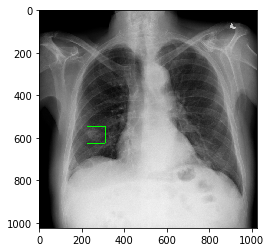

In [7]:
img = np.copy(ori_imgs_plot[0])
x1 = int(bbox_img['bbox'][0])
y1 = int(bbox_img['bbox'][1])
x2 = int(bbox_img['bbox'][0] + bbox_img['bbox'][2])
y2 = int(bbox_img['bbox'][1] + bbox_img['bbox'][3])

cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)

plt.imshow(img)

In [53]:
type(ori_imgs_plot[0])

numpy.ndarray

# Organize Visualize

In [1]:
def create_4_points(bbox):
    points = np.zeros((4, 2), dtype=int)
    points[0,0] = bbox[0]
    points[0,1] = bbox[1]
    points[1,0] = bbox[0] + bbox[2]
    points[1,1] = bbox[1]
    points[2,0] = bbox[0] + bbox[2]
    points[2,1] = bbox[1] + bbox[3]
    points[3,0] = bbox[0]
    points[3,1] = bbox[1] + bbox[3]
    points = points.reshape((-1, 1, 2))
    return points

In [27]:
import json
import torch
from torch.backends import cudnn

from backbone import EfficientDetBackbone
import cv2
import matplotlib.pyplot as plt
import numpy as np

from efficientdet.utils import BBoxTransform, ClipBoxes
from utils.utils import preprocess, invert_affine, postprocess

import os
os.chdir('/home/dxtien/dxtien_research/nmduy/Yet-Another-EfficientDet-Pytorch')

with open('/home/dxtien/dxtien_research/nmduy/data_covid_creation/data_pneu_bbox.json') as f:
    data_bbox = json.load(f)

full_id = list(data_bbox.keys()) # images id with folder
short_id = [x.split('/')[-1] for x in full_id] # images id


In [28]:
weight_path = 'logs/pneumonia_head_only_with_none/best_model/efficientdet-d4_68_11385.pth'
compound_coef = 4
force_input_size = None  # set None to use default size

threshold = 0.2
iou_threshold = 0.2

use_cuda = True
use_float16 = False
cudnn.fastest = True
cudnn.benchmark = True

obj_list = ['abnormal']

# tf bilinear interpolation is different from any other's, just make do
input_sizes = [512, 640, 768, 896, 1024, 1280, 1280, 1536]
input_size = input_sizes[compound_coef] if force_input_size is None else force_input_size

model = EfficientDetBackbone(compound_coef=compound_coef, num_classes=len(obj_list),

                             # replace this part with your project's anchor config
                             ratios=[(1.0, 1.0), (1.4, 0.7), (0.7, 1.4)],
                             scales=[2 ** 0, 2 ** (1.0 / 3.0), 2 ** (2.0 / 3.0)])

model.load_state_dict(torch.load(weight_path))
model.requires_grad_(False)
model.eval()

if use_cuda:
    model = model.cuda()
if use_float16:
    model = model.half()

In [29]:
imgs_path = '/home/dxtien/dxtien_research/nmduy/Yet-Another-EfficientDet-Pytorch/datasets/pneumonia_with_none/val/'
list_imgs = os.listdir(imgs_path)
list_imgs_path = [imgs_path + x for x in list_imgs]

In [50]:
for idx, img in enumerate(list_imgs[-100:-99]):
    bbox_img = data_bbox[full_id[short_id.index(img)]]
    if len(bbox_img['bbox']) > 0:
        gt_points = create_4_points(bbox_img['bbox'])
    else:
        gt_points = []


    ori_imgs, framed_imgs, framed_metas = preprocess(list_imgs_path[idx], max_size=input_size)

    ori_imgs_plot = [np.copy(x) for x in ori_imgs]
    if use_cuda:
        x = torch.stack([torch.from_numpy(fi).cuda() for fi in framed_imgs], 0)
    else:
        x = torch.stack([torch.from_numpy(fi) for fi in framed_imgs], 0)

    x = x.to(torch.float32 if not use_float16 else torch.float16).permute(0, 3, 1, 2)

    with torch.no_grad():
        features, regression, classification, anchors = model(x)

        regressBoxes = BBoxTransform()
        clipBoxes = ClipBoxes()

        out = postprocess(x,
                        anchors, regression, classification,
                        regressBoxes, clipBoxes,
                        threshold, iou_threshold)

    out = invert_affine(framed_metas, out)

    # PLOT #
    ori_imgs_plot = [np.copy(x) for x in ori_imgs]
    if len(gt_points) > 0:
        cv2.polylines(ori_imgs_plot[0], [gt_points], True, (0, 255, 0), 2);

    for i in range(len(ori_imgs_plot)):
        if len(out[i]['rois']) == 0:
            continue

        for j in range(len(out[i]['rois'])):
            score = float(out[i]['scores'][j])
            #if score >= 0.1:
            (x1, y1, x2, y2) = out[i]['rois'][j].astype(np.int)
            pred_box = [x1, y1, abs(x2-x1), abs(y2-y1)]
            pred_points = create_4_points(pred_box)
            cv2.polylines(ori_imgs_plot[i], [pred_points], True, (255, 0, 0), 2);
            
            cv2.putText(ori_imgs_plot[i], '{:.3f}'.format(score),
                        (x1, y1 + 10), cv2.FONT_HERSHEY_SIMPLEX, 2,
                        (0, 0, 255), 4);

            #plt.imshow(ori_imgs_plot[i])
   


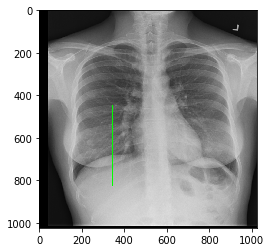

In [53]:
plt.imshow(ori_imgs_plot[0])

In [60]:
out

[{'rois': array([], dtype=float64),
  'class_ids': array([], dtype=float64),
  'scores': array([], dtype=float64)}]

In [57]:
from PIL import Image

In [58]:
a = Image.fromarray(ori_imgs_plot[0])

In [61]:
a.save('test.png')